In [1]:
import requests
import pandas as pd
import time
import tqdm
import networkx as nx
import plotly.graph_objects as go
import numpy as np

client = ''
secret = ''
auth = requests.auth.HTTPBasicAuth(client, secret)

In [2]:
data = {
    'grant_type': 'password',
    'username': '',
    'password': ''
}

headers = {'User-Agent': 'MyAPI/0.0.1'}
res = requests.post('https://www.reddit.com/api/v1/access_token', auth=auth, data=data, headers=headers)
token = res.json()['access_token']  
headers = {**headers, **{'Authorization': f'bearer {token}'}}

In [178]:
def fetch_posts(subreddit, headers, limit=100, max_posts=1000):
    posts = []
    after = None
    while len(posts) < max_posts:
        url = f'https://oauth.reddit.com/r/{subreddit}?limit={limit}'
        if after:
            url += f'&after={after}'
        
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            json_response = response.json()
            posts.extend(json_response['data']['children'])
            after = json_response['data'].get('after')
            if not after:
                break  # No more posts to fetch
        else:
            print(f"Failed to fetch posts: {response.status_code}")
            break
    
    return posts

def post_ids(posts):
    return [post['data']['id'] for post in posts]

def fetch_comments(subreddit,post_id, headers, limit=100, max_comments=1000):
    comments = []
    after = None
    while len(comments) < max_comments:
        url = f'https://oauth.reddit.com/r/{subreddit}/comments/{post_id}?limit={limit}'
        if after:
            url += f'&after={after}'
        
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            json_response = response.json()
            comments.extend(json_response[1]['data']['children'])
            after = json_response[1]['data'].get('after')
            if not after:
                break  # No more comments to fetch
        else:
            print(f"Failed to fetch comments: {response.status_code}")
            time.sleep(1)
            break
    
    return comments

In [179]:
# final code to get post, poster_name, comments and commentor_name to a dataframe. post and comments in 'content' , user in 'user' and a flag for post or comment in 'type'

def posts_to_df(subreddit, headers, limit=100, max_posts=1000):

    df = pd.DataFrame(columns=['content', 'user', 'type','subreddit','post_id'])

    posts = fetch_posts(subreddit, headers, limit=limit, max_posts=max_posts)

    for post in posts:
        new_row = pd.DataFrame({
        'content': [post['data']['title']],
        'user': [post['data']['author']],
        'type': ['post'],
        'subreddit': [subreddit],
        'post_id': [post['data']['id']]
        })
        df = pd.concat([df, new_row], ignore_index=True)

        comments = fetch_comments(subreddit,post['data']['id'], headers, limit=limit, max_comments=max_posts)
        
        for comment in comments:
            
            if 'body' not in comment['data']:
                continue
            
            new_row = pd.DataFrame({
            'content': [comment['data']['body']],
            'user': [comment['data']['author']],
            'type': ['comment'],
            'subreddit': [subreddit],
            'post_id': [post['data']['id']]
            })  
            df = pd.concat([df, new_row], ignore_index=True)

    return df


In [249]:
subreddits = ['democrats', 'republican','conservative','liberal']

posts_df = pd.DataFrame(columns=['content', 'user', 'type','subreddit','post_id'])

for subreddit in tqdm.tqdm(subreddits):
    posts_df_ = posts_to_df(subreddit, headers, limit=100, max_posts=5000)
    time.sleep(1000)
    posts_df = pd.concat([posts_df, posts_df_], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [1:28:01<00:00, 1320.44s/it]


#### Skip data download, and load from local

In [3]:
posts_df = pd.read_csv('reddit_posts.csv')
posts_df.to

,content,user,type,subreddit,post_id
0,WHAT JOE BIDEN HAS DONE,backpackwayne,post,democrats,1abzgfe
1,So many accomplishments. These need to be more...,Traditional-Grape-57,comment,democrats,1abzgfe
2,Campaign needs a nicely presented PDF of this....,Equivalent_Alps_8321,comment,democrats,1abzgfe
3,Just the recent $5 BILLION package for infras...,OpportunityDefiant31,comment,democrats,1abzgfe
4,How about another master post called Why Trump...,Gamecat93,comment,democrats,1abzgfe
...,...,...,...,...,...
25671,How accurate is this? Any suggestions on the s...,Dream_flakes,post,liberal,16nd2c6
25672,As someone who has lived in Florida for decade...,subterfuscation,comment,liberal,16nd2c6
25673,TikTok Faces Staggering €345 Million GDPR Fine...,Professional-Ad6429,post,liberal,16mzwe9
25674,Republicans constantly inciting violence with ...,Illustrious-Style-38,post,liberal,16mxr0r


In [4]:
# post id 1at245e

posts_df[posts_df['post_id'] == '1at245e']

,content,user,type,subreddit,post_id
19130,Trump supporters start GoFundMe page for $355M...,Hola0722,post,liberal,1at245e
19131,Which violates GFM’s rule against raising fund...,NeauxDoubt,comment,liberal,1at245e
19132,“Let’s start a fund for a guy even though he i...,hdiggyh,comment,liberal,1at245e
19133,Wow. What a stupid world.,One_Tomorrow_9135,comment,liberal,1at245e
19134,"And if anyone from New York donates, he is bre...",snowbyrd238,comment,liberal,1at245e
19135,that’s hilarious. a “billionaire “ with a go f...,melouofs,comment,liberal,1at245e
19136,He already has a “go fund me”. It’s called the...,MotherofHedgehogs,comment,liberal,1at245e
19137,Why doesn’t he pull himself up by his bootstraps?,Rhobaz,comment,liberal,1at245e
19138,He's not going to dip into his own pocket for ...,Technomage1,comment,liberal,1at245e
19139,Poor people will pay the legal fees for a self...,CannabisaurusRex401,comment,liberal,1at245e


In [2]:
posts_df = pd.read_csv('reddit_posts.csv')
posts_df = posts_df[posts_df['content'].str.contains('trump|biden', case=False)]
#posts lower and remove numbers and special characters
posts_df['content_original'] = posts_df['content']
posts_df['content'] = posts_df['content'].str.lower()
posts_df['content'] = posts_df['content'].str.replace('[^a-zA-Z\s]', '', regex=True)

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
list = ['trump','people','biden','republican','democrat','conservative','president','election','vote','voting','voted','votes','voter','joe','donald','trumps','bidens','republicans','democrats','gt']
for word in list:
    stop_words.add(word)

posts_df['content'] = posts_df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))



# lemmatize the words

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
posts_df['content'] = posts_df['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


# topic modeling

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(posts_df['content'])

lda_model = LatentDirichletAllocation(n_components=5, max_iter=10, learning_method='online', random_state=100, batch_size=32, n_jobs=-1)
lda_output = lda_model.fit_transform(data_vectorized)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uditdhand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uditdhand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
# print words and values for each topic
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        
print_topics(lda_model, vectorizer, 10)

Topic 0:
[('thing', 379.43298499582323), ('right', 338.5740599386589), ('gop', 279.9074187475845), ('border', 270.30357798574084), ('want', 253.34170651869695), ('party', 247.11627272916706), ('dont', 232.81476206784427), ('say', 218.65118776812167), ('think', 217.1951843860311), ('better', 215.40494622243466)]
Topic 1:
[('poll', 257.00156078028044), ('court', 230.5674700068074), ('case', 158.90418171262755), ('law', 136.37329102972043), ('new', 134.22719980163632), ('million', 127.19764104834381), ('judge', 120.87704859295381), ('state', 113.33981410127127), ('legal', 106.00071562789364), ('trial', 100.62054788482729)]
Topic 2:
[('american', 251.3483505784155), ('state', 213.66935387019848), ('voter', 207.14545113886328), ('support', 184.22344544844114), ('political', 158.87601218597078), ('didnt', 138.02873196001983), ('haley', 136.92218194610803), ('make', 128.80353888610404), ('world', 123.01832947340998), ('say', 122.18514868893189)]
Topic 3:
[('time', 369.89928027346775), ('know'

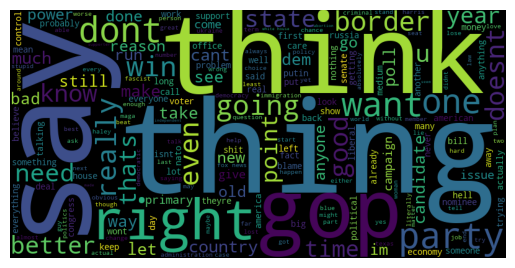

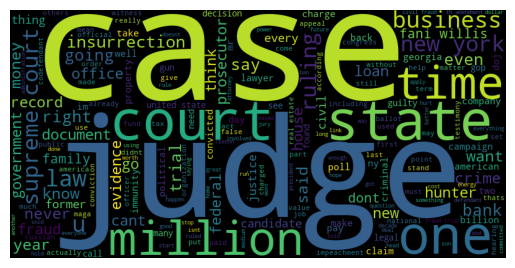

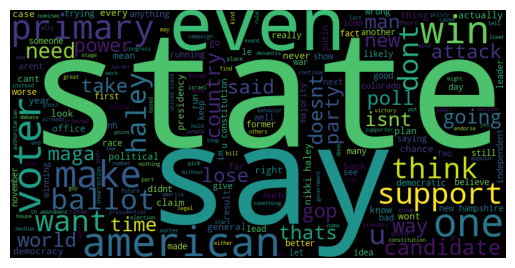

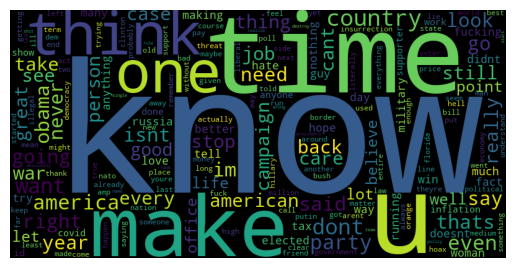

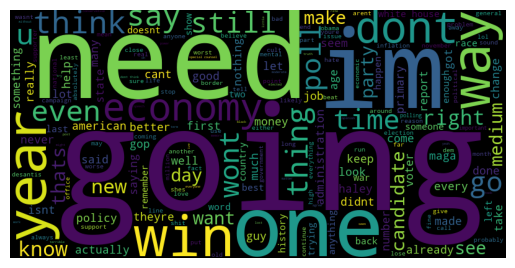

In [37]:
# create posts_df['topic'] based on the topic with the highest probability

posts_df['topic'] = lda_output.argmax(axis=1)

from wordcloud import WordCloud

for topic in range(5):
    wc = WordCloud(width=800, height=400, max_words=200).generate(posts_df[posts_df['topic'] == topic]['content'].str.cat(sep=' '))
    wc.to_file(f'topic_{topic}.png')

# display word cloud for each topic
    
from PIL import Image
import matplotlib.pyplot as plt

for topic in range(5):
    img = Image.open(f'topic_{topic}.png')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [38]:
# list of topic names

topic_names = {0: 'GOP and Immigration Policy', 1: 'Legal and Judicial Matters', 2: 'Voter and Political Dynamics', 3: 'Sociopolitical Discourse and National Identity', 4: 'Economic Concerns and Political Strategy'}

# update topics with names
posts_df['topic_str'] = posts_df['topic'].map(topic_names)

In [52]:

def create_graph(G):
    pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

    # Prepare edge traces
    edge_x = []
    edge_y = []
    edge_trace = []

    for (u, v, weight) in G.edges(data='weight'):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
        # Define edge color based on weight, this is customizable
        edge_color = 'red' if weight > 0 else 'blue'
        
        # Append a trace for each edge
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=float(np.abs(weight)), color=edge_color), # Weight-based thickness
            hoverinfo='none',
            mode='lines'))

    # Prepare node trace
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # color scale for nodes
            colorscale='YlGnBu',
            size=10,
            color=[],
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Add text to the nodes
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{adjacencies[0]} (#connections: {len(adjacencies[1])})')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    # Create the figure
    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=0),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        plot_bgcolor='rgba(0,0,0,0)'))

    # Display the figure
    fig.show()



In [53]:
# for a given network, provide metrics for the topics

def metrics(G):
    
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    metrics_df = pd.DataFrame(columns=['topic', 'subreddit','degree_centrality','closeness_centrality','betweenness_centrality'])

    for topic in posts_df['topic_str'].unique():
        new_row = pd.DataFrame({
        'topic': [topic],
        'subreddit': [subreddits],
        'degree_centrality': [degree_centrality[topic]],
        'closeness_centrality': [closeness_centrality[topic]],
        'betweenness_centrality': [betweenness_centrality[topic]]
        })
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

    return metrics_df


In [54]:
# create a network of users and topics

def network(df, subreddit, candidate):
    # list of subreddit filter
    df = df[(df['subreddit'].isin(subreddit)) & (df['content_original'].str.contains(candidate, case=False))]
    G = nx.Graph()
    for user, topic in zip(df['user'], df['topic_str']):
        if not G.has_node(user):
            G.add_node(user)
        if not G.has_node(topic):
            G.add_node(topic)
        if not G.has_edge(user, topic):
            G.add_edge(user, topic, weight=0)
        G[user][topic]['weight'] += 1

    return G

subreddits = ['democrats']
candidate = 'trump'
G = network(posts_df, subreddits, candidate)
create_graph(G)
metrics(G)


/var/folders/hg/kqg69xz568l28vnvcx6x09hh0000gn/T/ipykernel_8246/1058299007.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,topic,subreddit,degree_centrality,closeness_centrality,betweenness_centrality
0,GOP and Immigration Policy,[democrats],0.390203,0.451908,0.450196
1,Economic Concerns and Political Strategy,[democrats],0.310811,0.421652,0.344472
2,Voter and Political Dynamics,[democrats],0.251689,0.401628,0.281458
3,Sociopolitical Discourse and National Identity,[democrats],0.288851,0.413986,0.329528
4,Legal and Judicial Matters,[democrats],0.194257,0.383917,0.185974


## Extra Code

In [253]:
from transformers import AutoTokenizer

# Initialize the tokenizer for your model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tkn(text):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    return len(input_ids)

posts_df['token_length'] = posts_df['content'].apply(tkn)

posts_df = posts_df[posts_df['token_length']<512]

posts_df = posts_df[~posts_df['user'].isin(['AutoModerator', '[deleted]'])]
posts_df = posts_df[posts_df['content'].str.contains('trump|biden', case=False)]


Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors


In [254]:

sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_entity_sentiment_lightweight(text, entity):
    if entity.lower() not in text.lower():
        return None
    sentiment_result = sentiment_pipeline(text)[0]
    score = sentiment_result['score'] if sentiment_result['label'] == 'POSITIVE' else -sentiment_result['score']
    return score

posts_df['trump_score'] = posts_df['content'].apply(analyze_entity_sentiment_lightweight, entity='trump')
posts_df['biden_score'] = posts_df['content'].apply(analyze_entity_sentiment_lightweight, entity='biden')


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [265]:
posts_df = posts_df.fillna(0)

In [267]:

def create_interaction_network(df, subreddits=['democrats', 'republican','conservative','liberal']):
    G = nx.Graph()
    df = df[df['subreddit'].isin(subreddits)] 
    for post_id in df['post_id'].unique():
        #users = df[df['post_id'] == post_id]['user']
        commenter = df[(df['post_id'] == post_id) & (df['type'] == 'comment')]['user']
        post_author = df[(df['post_id'] == post_id) & (df['type'] == 'post')]['user']
        for u, v in itertools.product(commenter, post_author):
            if G.has_edge(u, v):
                G[u][v]['weight'] += 1#(df[(df['post_id'] == post_id) & (df['user'] == u)]['trump_score'].sum() - df[(df['post_id'] == post_id) & (df['user'] == u)]['biden_score'].sum())
            else:
                G.add_edge(u, v, weight=1)#(df[(df['post_id'] == post_id) & (df['user'] == u)]['trump_score'].sum() - df[(df['post_id'] == post_id) & (df['user'] == u)]['biden_score'].sum()))      
    return G

In [268]:

def create_graph_2(df):
    G = create_interaction_network(df)
    # Position nodes using the spring layout
    pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout

    # Prepare edge traces
    edge_x = []
    edge_y = []
    edge_trace = []

    for (u, v, weight) in G.edges(data='weight'):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
        # Define edge color based on weight, this is customizable
        edge_color = 'red' if weight > 0 else 'blue'
        
        # Append a trace for each edge
        edge_trace.append(go.Scatter(
            x=[x0, x1, None], y=[y0, y1, None],
            line=dict(width=float(np.abs(weight)), color=edge_color), # Weight-based thickness
            hoverinfo='none',
            mode='lines'))

    # Prepare node trace
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # color scale for nodes
            colorscale='YlGnBu',
            size=10,
            color=[],
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Add text to the nodes
    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append(f'{adjacencies[0]} (#connections: {len(adjacencies[1])})')

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    # Create the figure
    fig = go.Figure(data=edge_trace + [node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0,l=0,r=0,t=0),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        plot_bgcolor='rgba(0,0,0,0)'))

    # Display the figure
    fig.show()



In [269]:
# Build separate networks for Trump-related and Biden-related discussions. Nodes represent users, while edges represent interactions (e.g., comments on posts). Edge weights could be informed by sentiment scores

trump_df = posts_df[posts_df['trump_score'] != 0]
biden_df = posts_df[posts_df['biden_score'] != 0]

for subreddit in subreddits:
    # only current subreddit
    trump_df_tmp = trump_df[trump_df['subreddit'] == subreddit]
    print('subreddit:',subreddit)
    create_graph_2(trump_df_tmp)

for subreddit in subreddits:
    # only current subreddit
    biden_df_tmp = biden_df[biden_df['subreddit'] == subreddit]
    print('subreddit:',subreddit)
    create_graph_2(biden_df_tmp)

subreddit: democrats


subreddit: republican


subreddit: conservative


subreddit: liberal


subreddit: democrats


subreddit: republican


subreddit: conservative


subreddit: liberal


In [270]:
# weighted eigenvector centrality

def weighted_eigenvector_centrality(G):
    # Calculate the eigenvector centrality with increased maximum number of iterations
    centrality = nx.eigenvector_centrality(G,  max_iter=1000)
    return centrality

# Example
G = create_interaction_network(posts_df)
centrality = weighted_eigenvector_centrality(G)

# sort the centrality scores
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 users
sorted_centrality[:10]


sorted_centrality

[('intelligentreviews', 0.6412807722497237),
 ('interestingfactoid', 0.25997301834445685),
 ('RedBaronsBrother', 0.14032312222193377),
 ('StedeBonnet1', 0.12632586387092243),
 ('worlddestruction23', 0.10006002588947852),
 ('Tampammm', 0.09489586351906716),
 ('smauseth', 0.09334398038869943),
 ('MicahWeeks', 0.08888292538753526),
 ('2KALUBAFAK40z', 0.08778675263436495),
 ('blackdeviljohn', 0.08052799949047594),
 ('Accomplished_Shoe962', 0.07851314699103912),
 ('alrighty66', 0.0779430867160999),
 ('UncleMark58', 0.07765078432118017),
 ('Redline951', 0.07602329100214696),
 ('Comprehensive-End770', 0.07575529191590968),
 ('Comprehensive-Tell13', 0.06935812559611096),
 ('Nanteen1028', 0.06813857522178028),
 ('muxman', 0.06792739917084586),
 ('KingArthurOfBritons', 0.06760169584372559),
 ('mdws1977', 0.06665158307805712),
 ('Rodeocowboy123abc', 0.0665900025950122),
 ('supersmoked420', 0.06642250421536014),
 ('basesonballs', 0.06560335006760323),
 ('NoOne1950', 0.06560335006760323),
 ('Damsco

In [248]:
# posts from djackson404

posts_df[posts_df['user'] == 'djackson404']


,content,user,type,subreddit,post_id,token_length,trump_score,biden_score
258,"..yeah, this guy just needs to go home, sit do...",djackson404,comment,democrats,1at5ys2,26,0.000000,-0.994816
270,Couldn't happen to a nicer guy. 🤣\n\nThe ruina...,djackson404,comment,democrats,1at99yx,44,0.996440,0.000000
279,The Democrats need to show them this article: ...,djackson404,comment,democrats,1at5fzo,71,-0.999136,0.000000
760,If we get Biden re-elected then we can dismiss...,djackson404,comment,democrats,1arz5ft,102,-0.998317,-0.998317
947,"Here, let me sketch Trumps' future:\n\n* Strip...",djackson404,comment,democrats,1arpipo,29,-0.999651,0.000000
3151,The best way to 'Trump-proof' NATO and our ent...,djackson404,comment,liberal,1apsy9z,70,-0.998554,0.000000
3426,I think the same people that voted for Biden i...,djackson404,comment,liberal,1an71dm,90,0.000000,-0.996561
3952,I would talk to your boss (who hopefully isn't...,djackson404,comment,liberal,1af4913,136,-0.998078,0.000000


In [237]:
# 3. Community Detection
# Objective: Discover distinct communities within the subreddit that may correspond to specific political affiliations, ideologies, or topics of interest.
# Method: Use community detection algorithms like Louvain or Girvan-Newman to partition the network into communities. Analyze the content and sentiment of posts within each community to identify their political leanings or key issues.

import networkx as nx
import community.community_louvain as community_louvain

# Create a directed graph from the DataFrame
G = nx.from_pandas_edgelist(interaction_network_df, 'user1', 'user2', create_using=nx.Graph)

# Perform community detection using Louvain algorithm
partition = community_louvain.best_partition(G)

# Add the partition to the node trace
node_trace.marker.color = list(partition.values())
node_trace.text = list(partition.values())

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                     showlegend=False,
                     hovermode='closest',
                     margin=dict(b=0,l=0,r=0,t=0),
                     xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                     yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                     )

# Display the figure
fig.show()
node_trace.marker.color = list(partition.values())
node_trace.text = list(partition.values())

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))

                )




In [238]:
# Node Influence Measurement: Apply centrality measures (e.g., betweenness, eigenvector, or PageRank centrality) to identify the most influential nodes (users) within each subreddit's network. Influential nodes are those that act as major hubs or bridges in the dissemination of information.

def centrality_scores(G):
    # Calculate centrality scores
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)
    pagerank = nx.pagerank(G)
    
    # Create a DataFrame with the scores
    df = pd.DataFrame([degree_centrality, betweenness_centrality, eigenvector_centrality, pagerank]).T
    df.columns = ['degree', 'betweenness', 'eigenvector', 'pagerank']
    return df

centrality_scores(G).sort_values('pagerank', ascending=False).head(10)

,degree,betweenness,eigenvector,pagerank
interestingfactoid,0.294872,0.289981,0.388788,0.042211
intelligentreviews,0.253205,0.257622,0.275837,0.035423
Tampammm,0.179487,0.141943,0.280397,0.022741
StedeBonnet1,0.157051,0.144508,0.183258,0.021292
RedBaronsBrother,0.108974,0.100604,0.169739,0.016064
smauseth,0.118590,0.114369,0.186590,0.013393
alrighty66,0.086538,0.038252,0.162231,0.010540
MicahWeeks,0.080128,0.037636,0.170621,0.009773
2KALUBAFAK40z,0.067308,0.030153,0.128861,0.009288
Comprehensive-Tell13,0.070513,0.026563,0.130939,0.009009


In [239]:
# Information Flow Analysis: Construct directed graphs based on the interactions (comments, replies) to trace how information about Trump, Biden, or election-related topics flows. This can help you visualize and quantify the paths through which sentiments and opinions spread.

# Create a directed graph from the DataFrame

G = nx.from_pandas_edgelist(interaction_network_df, 'user1', 'user2', create_using=nx.DiGraph)

# Get positions for the nodes in G using the spring layout

pos = nx.spring_layout(G)

# Prepare edge traces

edge_x = []

edge_y = []

for edge in G.edges():
    
        x0, y0 = pos[edge[0]]
    
        x1, y1 = pos[edge[1]]
    
        edge_x.extend([x0, x1, None])  # add None to create a segment
    
        edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), hoverinfo='none', mode='lines')

# Prepare node traces

node_x = []

node_y = []

for node in pos:
        
            x, y = pos[node]
        
            node_x.append(x)
        
            node_y.append(y)

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text', marker=dict(showscale=True, colorscale='YlGnBu', size=10, color=[], colorbar=dict(thickness=15), line_width=2)
                            
    )

# Add text to the nodes (hover text)

node_adjacencies = []

node_text = []

for node, adjacencies in enumerate(G.adjacency()):
        
            node_adjacencies.append(len(adjacencies[1]))  # Number of connections
        
            node_text.append(f'{adjacencies[0]} (#connections: {len(adjacencies[1])})')

node_trace.marker.color = node_adjacencies

node_trace.text = node_text

# Create the figure

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=0),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )

# Display the figure

fig.show()

In [1]:
# Community Detection: Employ community detection algorithms (like Louvain method) to identify clusters within the networks. Analyzing these clusters can reveal subgroups with distinct characteristics, interests, or political leanings, and how these subgroups interact with the broader network.

import community.community_louvain as community_louvain

# Perform community detection using Louvain algorithm

partition = community_louvain.best_partition(G)

# Add the partition to the node trace

node_trace.marker.color = list(partition.values())

node_trace.text = list(partition.values())



NameError: name 'G' is not defined

<Axes: xlabel='about_trump'>

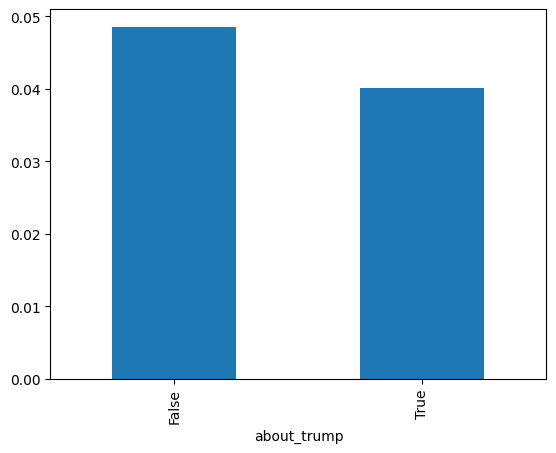

In [260]:
posts_df.groupby(['about_trump'])['sentiment'].mean().plot(kind='bar', stacked=True)